<a href="https://colab.research.google.com/github/Jeevikavishwakarma/Handwritten_text_generation_model/blob/main/Handwritten_Text_generation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install torch numpy matplotlib --quiet

In [ ]:
#Imports
import torch
import torch.nn as nn
import numpy as np
import matplotlib.pyplot as plt
from torch.utils.data import Dataset, DataLoader

In [ ]:
class CharEncoder(nn.Module):
    def __init__(self, vocab_size, embedding_dim):
        super(CharEncoder, self).__init__()
        self.embedding = nn.Embedding(vocab_size, embedding_dim)

    def forward(self, x):
        return self.embedding(x)

In [ ]:
class StrokeRNN(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim, num_layers=2):
        super(StrokeRNN, self).__init__()
        self.rnn = nn.LSTM(input_dim, hidden_dim, num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_dim, output_dim)

    def forward(self, x):
        output, _ = self.rnn(x)
        output = self.fc(output)
        return output

In [ ]:
def build_vocab():
    chars = list("abcdefghijklmnopqrstuvwxyzABCDEFGHIJKLMNOPQRSTUVWXYZ .,!?")
    stoi = {ch: i+1 for i, ch in enumerate(chars)}  # 0 is padding
    itos = {i+1: ch for ch, i in stoi.items()}
    return stoi, itos

In [ ]:
def text_to_tensor(text, stoi):
    indices = [stoi.get(ch, 0) for ch in text]
    return torch.tensor(indices).unsqueeze(0)  # shape: (1, len)


In [ ]:
def generate_handwriting(text, encoder, rnn, stoi):
    x = text_to_tensor(text, stoi)
    embedded = encoder(x)
    output = rnn(embedded).squeeze(0).detach().numpy()
    return output

In [ ]:
def plot_strokes(strokes):
    x, y = 0, 0
    pen = 0
    x_vals, y_vals = [], []
    for dx, dy, pen in strokes:
        x += dx
        y += dy
        if pen < 0.5:
            x_vals.append(x)
            y_vals.append(y)
        else:
            plt.plot(x_vals, y_vals, 'k-')
            x_vals, y_vals = [], []
    plt.plot(x_vals, y_vals, 'k-')
    plt.gca().invert_yaxis()
    plt.axis('off')
    plt.show()


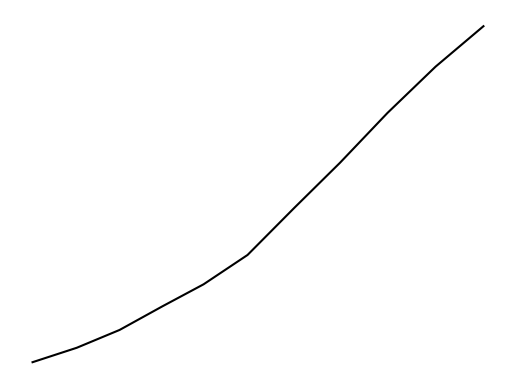

In [ ]:
# Config
vocab, _ = build_vocab()
encoder = CharEncoder(vocab_size=len(vocab)+1, embedding_dim=16)
rnn = StrokeRNN(input_dim=16, hidden_dim=128, output_dim=3)

# Generate handwriting
text = "hello world"
strokes = generate_handwriting(text, encoder, rnn, vocab)

# Scale outputs to look like strokes
strokes[:, :2] *= 2  # dx, dy
strokes[:, 2] = (strokes[:, 2] > 0).astype(float)  # pen state: 0/1

# Plot it
plot_strokes(strokes)

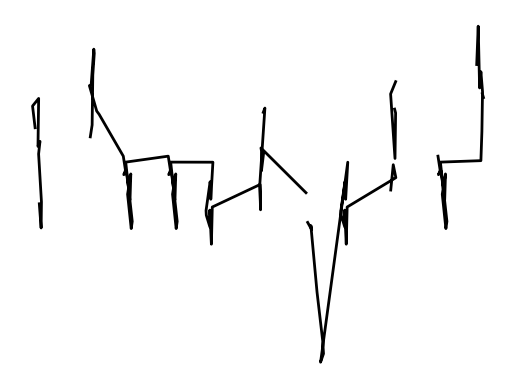

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

# Fake stroke generator for characters
def stroke_for_char(char, offset=0):
    np.random.seed(ord(char))  # make it deterministic per character
    strokes = []
    x, y = offset, 0
    for _ in range(10):
        dx = np.random.randn() * 0.5
        dy = np.random.randn() * 0.5
        pen = 0 if np.random.rand() > 0.1 else 1
        x += dx
        y += dy
        strokes.append([x, y, pen])
    return strokes

# Combine strokes for a word
def generate_strokes_for_text(text):
    full_stroke = []
    offset = 0
    for ch in text:
        stroke = stroke_for_char(ch, offset)
        full_stroke.extend(stroke)
        offset += 8  # space between characters
    return np.array(full_stroke)

# Plotting strokes
def plot_strokes(stroke_seq):
    x_vals, y_vals = [], []
    for x, y, pen in stroke_seq:
        if pen < 0.5:
            x_vals.append(x)
            y_vals.append(y)
        else:
            plt.plot(x_vals, y_vals, 'k-', linewidth=2)
            x_vals, y_vals = [], []
    plt.plot(x_vals, y_vals, 'k-', linewidth=2)
    plt.gca().invert_yaxis()
    plt.axis('off')
    plt.show()

# 👇 Try it with your own text
text_input = "hello world"
generated = generate_strokes_for_text(text_input)
plot_strokes(generated)